# K-Means及K-Medoid
## 1 算法简介
通常意义上接触的聚类问题是一个按照相似性（距离）进行样本聚集的过程，即把相似的（或距离近的）样本聚为同一类，而把不相似的（或距离远的）样本归在其他类。

我们以一个二维的例子来说明聚类的目的。如下图左所示，假设我们的n个样本点分布在图中所示的二维空间。从数据点的大致形状可以看出它们大致聚为三个簇，其中两个紧凑一些，剩下那个松散一些。我们的目的是为这些数据分组，以便能区分出属于不同的簇的数据，如果按照分组给它们标上不同的颜色，就是像下图右边的图那样：
![fig1](./Img/fig1.png)

我们知道，当人肉眼观察到上述的数据样本分布图的时候，很容易人工进行聚类。在机器学习中，我们运用k-means算法和k-medoid算法实现相类似的聚类工作。k-means算法是一种很常见的聚类算法，它的基本思想是：通过迭代寻找k个聚类的一种划分方案，使得用这k个聚类的均值来代表相应各类样本时所得的总体误差最小。

k-means算法的基础是最小误差平方和准则。其代价函数是：
$$J(c,\mu) = \sum_{i=1}^k {\|x^{(i)}-\mu_{c(i)}\|}^2$$
 
式中，$μ_{c(i)}$表示第$i$个聚类的均值。

我们希望代价函数最小，直观的来说，各个簇内的样本越相似，那么簇内样本点与该簇均值间的误差平方和越小，不断调整簇的均值即means值，即可寻找到聚成$k$个簇时，最优的聚类方案。


## 2 算法过程

代价函数无法用解析的方法最小化，只能有迭代的方法。k-means算法是将样本聚类成 k个簇（cluster），其中k是用户给定的，其求解过程非常直观简单，具体算法描述如下：

1、随机选取 k个聚类质心点

2、重复下面过程直到$\mu_j$收敛  

{

  对于每一个样例 i，计算其应该属于的类：

$$c^{(i)} = arg \min_j {\|x^{(i)}-\mu_{j}\|}^2$$

   对于每一个类 j，重新计算该类的质心：
$$\mu_j := \frac{\sum_{i=1}^{m}\{ c^{(i)} = j \} x^{(i)}}{\sum_{i=1}^{m}\{ c^{(i)} = j \}}$$


}

下图展示了对n个样本点进行K-means聚类的效果，这里k取2。$^{[2]}$

（a）在开始时，所有点都是绿色，表示初始样本点并未进行聚类划分

（b）指定2个means初始值，作为两个簇的初始均值，分别染色成红色和蓝色

（c）计算所有点到两个均值点的距离，根据距离的远近判断该点在第一次聚类所属的簇，若离红点近，则被聚类到红色的簇内。否则，被聚类到蓝色的簇内，此时所有点都被聚到两个簇内

（d）重新计算红蓝两个簇的均值，作为新的簇的均值点。

（e）基于新的均值点重复(c)(d)两个过程，直至均值点不再发生改变为止（收敛），聚类完成
![fig2](./Img/fig2.png)

## 3 代码分析
k-means算法思路总体而言比较简单，但也有几个比较大的缺点：

(1) k值的选择是用户指定的，不同的k得到的结果有时会产生很大的不同，如下图所示，左边是k=3的结果，红色簇内数据点过于稀疏，而蓝色簇其实是可以再划分成两个簇的。而右图是k=5的结果，此时红色簇和蓝色簇又可以合并成一个簇：
![fig3](./Img/fig3.png)
(2) 对k个初始质心的选择比较敏感，容易陷入局部最优解。例如，在上述算法运行时，有可能会在K-means收敛时，收敛到了局部最优值：
![fig4](./Img/fig4.png)
(3) 存在局限性，非球状的数据分布不适合用K-Means聚类：
![fig5](./Img/fig5.png)
(4) 数据量比较大的时候，收敛过程会比较慢。

## 4 代码实现
下面进行k-means算法的代码实现，首先导入相关的库函数：

In [7]:
%matplotlib inline

from numpy import *
import time
import matplotlib.pyplot as plt

建立相关的功能函数实现聚类功能：

In [8]:
# euclDistance函数计算两个向量之间的欧氏距离
def euclDistance(vector1, vector2):
    return sqrt(sum(power(vector2 - vector1, 2)))

# initCentroids选取任意数据集中任意样本点作为初始均值点
# dataSet: 数据集， k: 人为设定的聚类簇数目
# centroids： 随机选取的初始均值点
def initCentroids(dataSet, k):
    numSamples, dim = dataSet.shape
    centroids = zeros((k, dim))
    for i in range(k):
        index = int(random.uniform(0, numSamples))
        centroids[i, :] = dataSet[index, :]
    return centroids

# kmeans: k-means聚类功能主函数
# 输入：dataSet-数据集，k-人为设定的聚类簇数目
# 输出：centroids-k个聚类簇的均值点，clusterAssment－聚类簇中的数据点
def kmeans(dataSet, k):
    numSamples = dataSet.shape[0]
    
    clusterAssment = mat(zeros((numSamples, 2)))
    # clusterAssment第一列存储当前点所在的簇
    # clusterAssment第二列存储点与质心点的距离
    clusterChanged = True

    ## 步骤一: 初始化均值点
    centroids = initCentroids(dataSet, k)

    while clusterChanged:
        clusterChanged = False
        ## 遍历每一个样本点
        for i in range(numSamples):
            # minDist：最近距离
            # minIndex：最近的均值点编号
            minDist  = 100000.0
            minIndex = 0
            ## 步骤二: 寻找最近的均值点
            for j in range(k):
                distance = euclDistance(centroids[j, :], dataSet[i, :])
                if distance < minDist:
                    minDist  = distance
                    minIndex = j

            ## 步骤三: 更新所属簇
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
                clusterAssment[i, :] = minIndex, minDist**2

        ## 步骤四: 更新簇的均值点
        for j in range(k):
            pointsInCluster = dataSet[nonzero(clusterAssment[:, 0].A == j)[0]]
            centroids[j, :] = mean(pointsInCluster, axis = 0)

    print ('Congratulations, cluster complete!')
    return centroids, clusterAssment

# showCluster利用pyplot绘图显示聚类结果（二维平面）
# 输入:dataSet-数据集，k-聚类簇数目，centroids-聚类簇的均值点，clusterAssment－聚类簇中数据点
def showCluster(dataSet, k, centroids, clusterAssment):
    numSamples, dim = dataSet.shape
    if dim != 2:
        print ("Sorry, the dimension of your data is not 2!")
        return 1

    mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
    if k > len(mark):
        return 1

    # 画出所有的样本点
    for i in range(numSamples):
        markIndex = int(clusterAssment[i, 0])
        plt.plot(dataSet[i, 0], dataSet[i, 1], mark[markIndex])

    mark = ['Dr', 'Db', 'Dg', 'Dk', '^b', '+b', 'sb', 'db', '<b', 'pb']
    # 标记簇的质心
    for i in range(k):
        plt.plot(centroids[i, 0], centroids[i, 1], mark[i], markersize = 12)

    plt.show()

在主函数中执行聚类操作：

Congratulations, cluster complete!


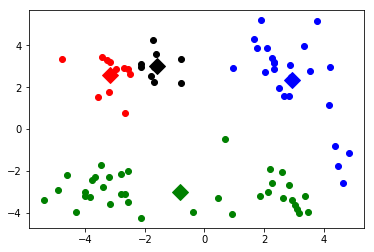

In [9]:
## step 1: 载入数据
dataSet = []
fileIn = open('./Input/Data.txt')
for line in fileIn.readlines():
    lineArr = line.strip().split('\t')
    dataSet.append([float(lineArr[0]), float(lineArr[1])])

## step 2: 开始聚类...
dataSet = mat(dataSet)
k = 4
centroids, clusterAssment = kmeans(dataSet, k)

## step 3: 显示聚类结果
showCluster(dataSet, k, centroids, clusterAssment)

不同的类用不同的颜色来表示，其中的正方形是对应类的均值质心点。
>**练习：**大家可以尝试修改不同的k值，观察聚类效果的变化。

# 5 课后练习
在练习中，请同学们完成k-means的变种算法，k-medoid算法。

k-medoids 和 k-means 不一样的地方在于中心点的选取，在 k-means 中，我们将中心点取为当前 cluster 中所有数据点的平均值。并且我们已经证明在固定了各个数据点的 assignment 的情况下，这样选取的中心点能够把目标函数 $J$ 最小化。然而在 k-medoids 中，我们将中心点的选取限制在当前 cluster 所包含的数据点的集合中。换句话说，在 k-medoids 算法中，我们将从当前 cluster 中选取这样一个点——它到其他所有（当前 cluster 中的）点的距离之和最小——作为中心点。k-means 和 k-medoids 之间的差异就类似于一个数据样本的均值 (mean) 和中位数 (median) 之间的差异：前者的取值范围可以是连续空间中的任意值，而后者只能在给样本给定的那些点里面选。
![fig6](./Img/fig7.png)
一个最直接的理由就是 k-means 对数据的要求太高了，它使用欧氏距离描述数据点之间的差异 (dissimilarity) ，从而可以直接通过求均值来计算中心点。这要求数据点处在一个欧氏空间之中。

然而并不是所有的数据都能满足这样的要求，对于数值类型的特征，比如身高，可以很自然地用这样的方式来处理，但是类别 (categorical) 类型的特征就不行了，类别是一个离散的量，无法获得常规的均值，这时我们需要利用K-Medoid算法去处理。

除此之外，由于中心点是在已有的数据点里面选取的，因此相对于 k-means 来说，K-Medoid算法不容易受到那些由于误差之类的原因产生的噪声干扰。

K-medoid算法具体流程如下：

1）任意选取K个对象作为medoids$（O_1,O_2,…O_i…O_k）$。　　

2）将余下的对象分到各个类中去（根据与medoid最相近的原则）；　　

3）对于每个类$（O_i）$中，顺序选取一个$O_r$，计算用$O_r$代替$O_i$后的消耗$E（O_r）$。选择E最小的那个$O_r$来代替$O_i$。这样K个medoids就改变了。

4）重复2、3步直到K个medoids固定下来。

当Medoids固定时，聚类也就完成了。

下面请同学们参考K-means的代码，实现K-medoid聚类，首先导入数据集和可能用到的相关的模块：

In [10]:
%matplotlib inline
# import _pickle as cPickle
from matplotlib import pyplot
from numpy import zeros, array, tile
from scipy.linalg import norm
import numpy.matlib as ml
import random

import Input.data

请同学们在kmedoids函数中实现聚类的功能，并通过调用kmedoids函数完成聚类效果的展示：

In [21]:
def medoid(pointsInCluster,centroid):
    minDist = euclDistance(centroid, pointsInCluster)
    newCentroid = centroid
    for i in range(len(pointsInCluster)):
        distance = euclDistance(pointsInCluster[i],pointsInCluster)
        if distance < minDist:
            minDist  = distance
            newCentroid = pointsInCluster[i]
    return newCentroid
def kmedoids(dataSet, k):
    numSamples = dataSet.shape[0]
    
    clusterAssment = mat(zeros((numSamples, 2)))
    # clusterAssment第一列存储当前点所在的簇
    # clusterAssment第二列存储点与质心点的距离
    clusterChanged = True

    ## 步骤一: 初始化均值点
    centroids = initCentroids(dataSet, k)

    while clusterChanged:
        clusterChanged = False
        ## 遍历每一个样本点
        for i in range(numSamples):
            # minDist：最近距离
            # minIndex：最近的均值点编号
            minDist  = 100000.0
            minIndex = 0
            ## 步骤二: 寻找最近的均值点
            for j in range(k):
                distance = euclDistance(centroids[j, :], dataSet[i, :])
                if distance < minDist:
                    minDist  = distance
                    minIndex = j

            ## 步骤三: 更新所属簇
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
                clusterAssment[i, :] = minIndex, minDist**2

        ## 步骤四: 更新簇的均值点
        for j in range(k):
            pointsInCluster = dataSet[nonzero(clusterAssment[:, 0].A == j)[0]]
            centroids[j, :] = medoid(pointsInCluster,centroids[j, :])

    print ('Congratulations, cluster complete!')
    return centroids, clusterAssment

Congratulations, cluster complete!


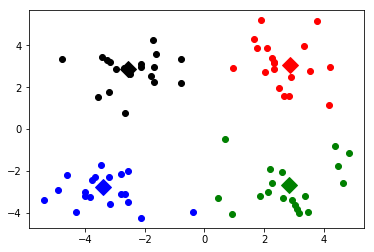

In [22]:
## step 1: 载入数据
dataSet = []
fileIn = open('./Input/Data.txt')
for line in fileIn.readlines():
    lineArr = line.strip().split('\t')
    dataSet.append([float(lineArr[0]), float(lineArr[1])])

## step 2: 开始聚类...
dataSet = mat(dataSet)
k = 4
centroids, clusterAssment = kmedoids(dataSet, k)

## step 3: 显示聚类结果
showCluster(dataSet, k, centroids, clusterAssment)

# 引用和参考资料列表
1.[@哥伦比亚大学机器学习课程（课件P7-P19）](https://courses.edx.org/asset-v1:ColumbiaX+CSMM.102x+2T2017+type@asset+block@ML_lecture14.pdf)

2.[@机器学习算法与Python实践之（五）k均值聚类（k-means)](http://blog.csdn.net/zouxy09/article/details/17589329)

3.[@K-means聚类算法](http://www.cnblogs.com/jerrylead/archive/2011/04/06/2006910.html)

4.[@K-means 维基百科](https://en.wikipedia.org/wiki/K-means_clustering)
